<h1 style = "text-align: center">Applied Machine Learning Project</h1>
<h2 style = "text-align: center">Zoé Kanounnikoff</h2>


We start by importing our data and separating predictors from the dependant variable.

In [11]:
import pandas as pd
import numpy as np

data = pd.read_csv('dataR2.csv')

X = data.iloc[:,:-1]
y = data['Classification'].apply(lambda x : x - 1) # we apply a transformation so that the categorical variable is 0 or 1 and not 1 or 2


Let's create a pipeline for data preprocessing. As the dataset doesn't have any missing value, the only step is scaling the data, using StandardScaler().

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([("Scaler", StandardScaler())])

X_preprocessed = pipe.fit_transform(X)

X = pd.DataFrame( data = X_preprocessed, columns = X.columns )


The first model we implement is Random Forests. We have two parameters to optimize : the number of trees used in the model and the maximum of features. We first optimize the number of trees, by using cross validation.

In [25]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
estimator_range = range(10, 310, 10)

rmse_scores = []

for estimator in estimator_range:
    rf_clf = RandomForestClassifier( n_estimators = estimator, random_state = 42 )
    mse_scores = cross_val_score(rf_clf, X_train, y_train, scoring = 'neg_mean_squared_error', n_jobs = 1, cv = 5)
    rmse_scores.append(np.mean(np.sqrt(-mse_scores)))

We plot the RMSE with n_estimator :

AttributeError: 'Line2D' object has no property 'figsize'

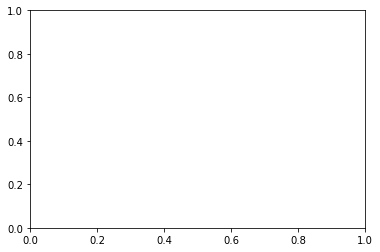

In [59]:
import matplotlib.pyplot as plt

plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()

Finally, we get the optimal parameter by taking the minimum of the RMSE list. 

In [27]:
L = []

for k in range(len(estimator_range)):
    L.append((rmse_scores[k], estimator_range[k],))
    
L_sorted = sorted(L)
err, num_est = L_sorted[0]
print('Minimum error is {} and its corresponding number of estimators is {}.'.format(err, num_est))

Minimum error is 0.565992029343189 and its corresponding number of estimators is 200.


Now we repeat the same method to optimize max_feature.

In [28]:
feature_range = range(1, data.shape[1])
rmse_scores_feat = []

for feature in feature_range:
    rf_clf = RandomForestClassifier(n_estimators=num_est, max_features=feature, random_state=42)
    mse_scores_feat = cross_val_score(rf_clf, X_train, y_train, scoring = 'neg_mean_squared_error', n_jobs = 1, cv = 5)
    rmse_scores_feat.append(np.mean(np.sqrt(-mse_scores_feat)))

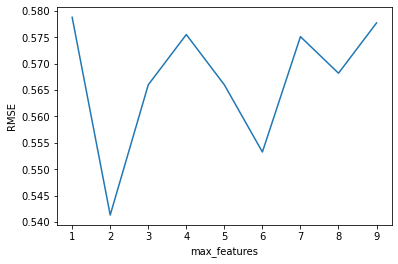

In [29]:
plt.plot(feature_range, rmse_scores_feat)
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.show()

In [30]:
L = []

for k in range(len(feature_range)):
    L.append((rmse_scores_feat[k], feature_range[k],))
    
L_sorted = sorted(L)
err_feat, max_feat = L_sorted[0]
print('Minimum error is {} and its corresponding maximum number of features is {}.'.format(err_feat, max_feat))

Minimum error is 0.5413227993039722 and its corresponding maximum number of features is 2.


Now, we can train the model with the good parameters.

In [32]:
rf_clf = RandomForestClassifier(n_estimators = num_est, max_features = max_feat, random_state = 42)
rf_clf.fit(X_train, y_train)
train_score = rf_clf.score(X_train, y_train)
test_score = rf_clf.score(X_test, y_test)

print('Train score is {}% and test score is {}%.'.format(train_score*100, test_score*100))

Train score is 100.0% and test score is 79.3103448275862%.


Let's get feature importance :

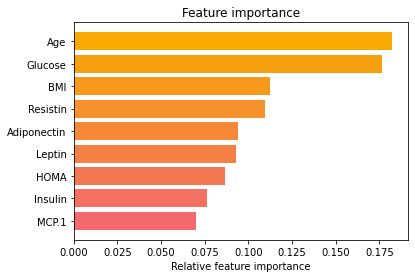

In [56]:
feat_imp = rf_clf.feature_importances_
indices = np.argsort(feat_imp)

plt.barh(range(len(indices)), feat_imp[indices], color = ["#F3696E","#F47161","#F47953","#F58146","#F68938","#F6912B","#F7991D","#F7A110","#F8A902"])
plt.yticks(range(len(indices)), [data.columns[i] for i in indices])
plt.xlabel('Relative feature importance')
plt.title('Feature importance')
plt.show()


ROC curve :

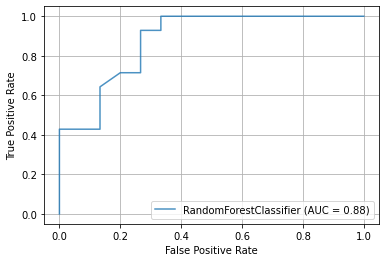

In [58]:
from sklearn.metrics import plot_roc_curve, confusion_matrix

rf_roc = plot_roc_curve(rf_clf, X_test, y_test, alpha = 0.8 )
plt.grid()
plt.show()


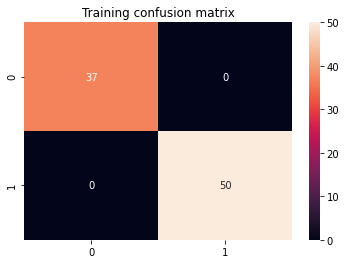

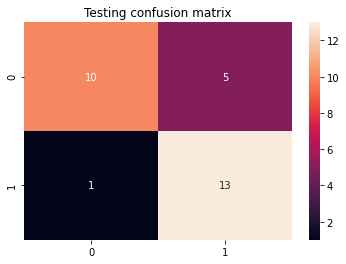

In [41]:
y_pred_train = rf_clf.predict( X_train )
y_pred_test = rf_clf.predict( X_test )

cm_train = confusion_matrix( y_train, y_pred_train )
cm_test = confusion_matrix( y_test, y_pred_test )

import seaborn
seaborn.heatmap(cm_train, annot = True )
plt.title( 'Training confusion matrix' )
plt.show()
seaborn.heatmap(cm_test, annot = True)
plt.title( 'Testing confusion matrix' )
plt.show()

In [43]:
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

sensitivity = tp_test/(tp_test + fn_test)
specificity = tn_test/(tn_test + fp_test)
precision = tp_test/(tp_test + fp_test)

print((sensitivity, specificity, precision))

(0.9285714285714286, 0.6666666666666666, 0.7222222222222222)
